In [28]:
%load_ext autoreload
%autoreload 2

#standard imports
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

#rl book imports
import rl
from rl.markov_decision_process import MarkovDecisionProcess
from rl.markov_process import State, MarkovProcess, NonTerminal, Terminal

from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)


from rl.distribution import Categorical, Distribution, Constant, Choose
from rl.policy import Policy
from rl.monte_carlo import epsilon_greedy_policy, greedy_policy_from_qvf, glie_mc_control, mc_prediction
from rl.function_approx import LinearFunctionApprox, AdamGradient, Weights
from rl.td import glie_sarsa, q_learning
from rl.td_lambda import td_lambda_prediction


#custom imports 
import utils as u
import data as dat
import mdp_agent as ag
import baseline_policies as bp
import q_plots as qp
import backtest as btest
import v_predictor as v_true

import pickle 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [71]:
constant_params = {
    "mu":   lambda t : 100,
    "sigma": lambda t : 0.2,
    "kappa":  lambda t : 1/10
}

time_varying_params = {
    "mu":   lambda t : 100 + t*0.005,
    "kappa":   lambda t : 1/(15+5*np.cos(np.pi*t/30)),
    "sigma":    lambda t: 0.2    
}

params = constant_params

In [72]:
train, test = dat.build_simulated_train_test(N=10,mu=params["mu"],sigma=params["sigma"],kappa=params["kappa"])
u.plot_plotly_multiple(train)

# Load predictor

In [73]:
def intercept(x):
    return 1

def z_score_state(x):
    return (x.state["Spot"] - x.state["mu_t"])/(x.state["sigma_t"])
    

v_approx = LinearFunctionApprox.create(feature_functions=[intercept,z_score_state],weights=Weights(weights = np.array([-0.0017381 , -0.00776148]),
                                                                                        adam_cache1=0,adam_cache2=0,adam_gradient=0,time=0))

In [90]:
trader = ag.Trading(train,test)


def get_list_states(trd):

    mrp = trd.apply_policy(bp.BuyAndHold())

    start_states = trd.generate_start_state("train") # we take the test set data of the trading policy
    sequence = trd.simulate_actions(start_states, bp.BuyAndHold())

    states = [] #will be used to build the backtest dataframe

    for x in sequence:

        states.append(x.state)

    return states

history = [get_list_states(trader)]

In [102]:
import v_plots2 as v2

V_analyze = v2.V_Analyzer_Mehdi(v_approx,history)

x_range, t_range, f_values = V_analyze.generate_V_heatmap()



In [103]:
V_analyze.plot_heatmap(list(x_range),t_range,f_values)

# Backtest

In [36]:
v_policy = bp.ActionFromV(v_approx,enter_long = 0.001,exit_long = 0.0005,enter_short=-0.001,exit_short= -0.0005)

trader = ag.Trading(train,test)
bt = btest.Backtester(trader, v_policy)
bt.summary()

/Users/mehdi/Desktop/cme241/RL_Project/utils.py:97: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



# Real data

In [107]:
def intercept(x):
    return 1

def z_score_state(x):
    return (x.state["Spot"] - x.state["mu_t"])/(x.state["sigma_t"])

def trend_mu(x):
    return (x.state["trend"])

def ar1(x):
    return (x.state["ar1"])


v_fitted = LinearFunctionApprox(feature_functions=[intercept,z_score_state,trend_mu,ar1], 
                                regularization_coeff=0.0,
                                weights=Weights(adam_gradient=AdamGradient(learning_rate=0.0001, decay1=0.9, decay2=0.999),
                                time=99,
                                weights=np.array([ 0.00045582, -0.00117238,  0.00014746,  0.0003777 ]),
                                adam_cache1=np.array([-2.16022668e-04,  3.70939446e-04, -7.17398510e-07, -1.57799696e-04]),
                                adam_cache2=np.array([9.24243556e-07, 7.77245521e-07, 2.67186720e-11, 6.99101537e-07])),
                                direct_solve=False)

In [109]:
with open("FX_Residuals/residuals_PCA_2F_3_1.pkl","rb") as f:
    fx_data = pickle.load(f)

In [121]:
u.plot_plotly((1+fx_data[["ZAR"]]).cumprod())

<AxesSubplot:xlabel='date'>

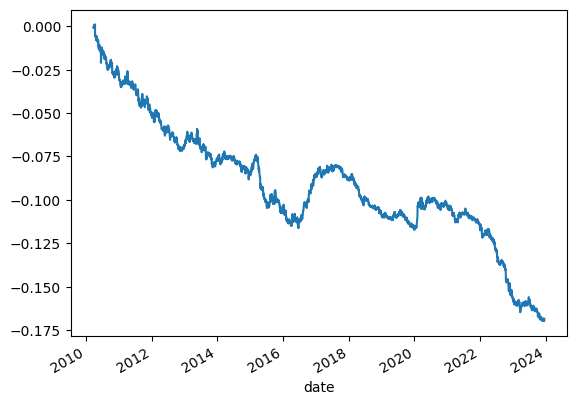

In [113]:
fx_data["SGD"].cumsum().plot()

In [110]:

for which_ccy in list(fx_data.columns):

    print(which_ccy)

    v_policy = bp.ActionFromV(v_fitted,enter_long = 0.001,exit_long = 0.0005,enter_short=-0.001,exit_short= -0.0005)

    residual = pd.DataFrame((1+fx_data[which_ccy]).cumprod())

    trader = ag.Trading([residual],residual)
    bt = btest.Backtester(trader, v_policy)
    bt.summary()

SGD


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



JPY


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



INR


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



THB


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



ZAR


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



IDR


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



TWD


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



KRW


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



HUF


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



CHF


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



MYR


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



PHP


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



BRL


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



MXN


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



COP


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



CLP


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



CAD


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



EUR


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



GBP


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



AUD


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



NZD


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



NOK


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



SEK


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



CZK


/Users/mehdi/Desktop/cme241/RL_Project/utils.py:106: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

